In [1]:
#!nvidia-smi

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [3]:
configs = {
    "batch_size" : 32,
    "max_file_count" : 2179,
    "train_file" : 7,
    "validation_file" : 3,
    "test_file" : 3,
    "input_size" : 8,
    "output_size" : 1,
    "init_learning_rate" : 1e-4,
    "scheduler_factor": 0.5,
    "scheduler_patience": 2,
    "scheduler_min_lr": 3e-6,
    "epoch" : 15,
    "model_name" : "LSTM8",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
tickers = list(map(str.strip,open("tickers_sp500.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/51826 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/27127 [00:00<?, ?it/s]

d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/32244 [00:00<?, ?it/s]

d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)


In [4]:
torch.set_default_dtype(torch.float32)

class LSTMBlock(nn.Module) :
    def __init__(self, input_size, output_size) :
        super().__init__()
        self.LSTM = nn.LSTM(input_size,output_size,2,batch_first=True,bias=False)
        self.Dropout = nn.Dropout(p=0.2)
        self.LayerNorm = nn.LayerNorm(output_size)
    
    def forward(self, input) :
        h1,_ = self.LSTM(input)
        h2 = self.Dropout(h1)
        output = self.LayerNorm(h2)
        return output

class StockLSTM(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 512
        self.batch_size = configs["batch_size"]
        self.layer1 = LSTMBlock(6,self.hidden_size)
        self.layer2 = nn.Linear(self.hidden_size,1,bias=False)

    def forward(self, input) :
        input = torch.multiply(input,25)
        h1 = self.layer1(input)
        output = self.layer2(h1[:,-1,:])
        output = torch.multiply(output,0.04)
        return output


In [16]:
# temp const
scaler = torch.tensor((np.array([0.04,1,1,1,1,0.02]).reshape(-1,1) @ np.array([1] * configs["input_size"]).reshape(1,-1)).T)
scaler = scaler.type(torch.float32)

In [19]:
model = StockLSTM()
model = model.to(device)

# summary(model,input_size=(configs["batch_size"],configs["input_size"],6))

In [21]:
try_input = torch.zeros(configs["batch_size"],configs["input_size"],6)
try_input = try_input.to(device=device)

dataset = model(try_input)

In [22]:
# L1loss_function = torch.nn.L1Loss()

# def loss_fn(target, input) :
#     penalty = 0.005
#     return torch.mul(torch.mean(torch.lt(torch.mul(target,input),0).type(torch.float32)),penalty) + L1loss_function(target,input)

loss_fn = torch.nn.L1Loss()

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)


In [25]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000



for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    learning_rates.append(optimizer.param_groups[0]['lr'])

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = torch.mul(torch.transpose(input[:,:,:],1,2),scaler)
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = torch.mul(torch.transpose(input[:,:,:],1,2),scaler)
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))
        avarage_val_losses.append(avarage_val_loss)

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            best_loss = avarage_val_loss

            torch.save(state, model_folder + "LSTM.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

train loss :  0.015795999497101584
val loss :  0.017277388536583504


  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

train loss :  0.01535437547804821
val loss :  0.017317621056056432


  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

train loss :  0.015323987650300174
val loss :  0.0172886337475783


  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

train loss :  0.01529693467757671
val loss :  0.017292884319202607


  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

train loss :  0.015263125059954762
val loss :  0.01727402534384232


  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

train loss :  0.015261782128179769
val loss :  0.01726566913945616


  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

train loss :  0.015254945210638497
val loss :  0.01728589470314638


  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

train loss :  0.015252150249753177
val loss :  0.017305449066945346


  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

train loss :  0.015244356983866477
val loss :  0.017288834157860547


  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

train loss :  0.015236188530740158
val loss :  0.017261031179423878


  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

train loss :  0.015234553691752167
val loss :  0.01727594103039613


  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

train loss :  0.015223964235105122
val loss :  0.017295963030831873


  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

train loss :  0.015219519412981426
val loss :  0.017288631406626988


  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

train loss :  0.015216186428943061
val loss :  0.017285464394182284


  0%|          | 0/1620 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

train loss :  0.015213936770943449
val loss :  0.017295572974904933


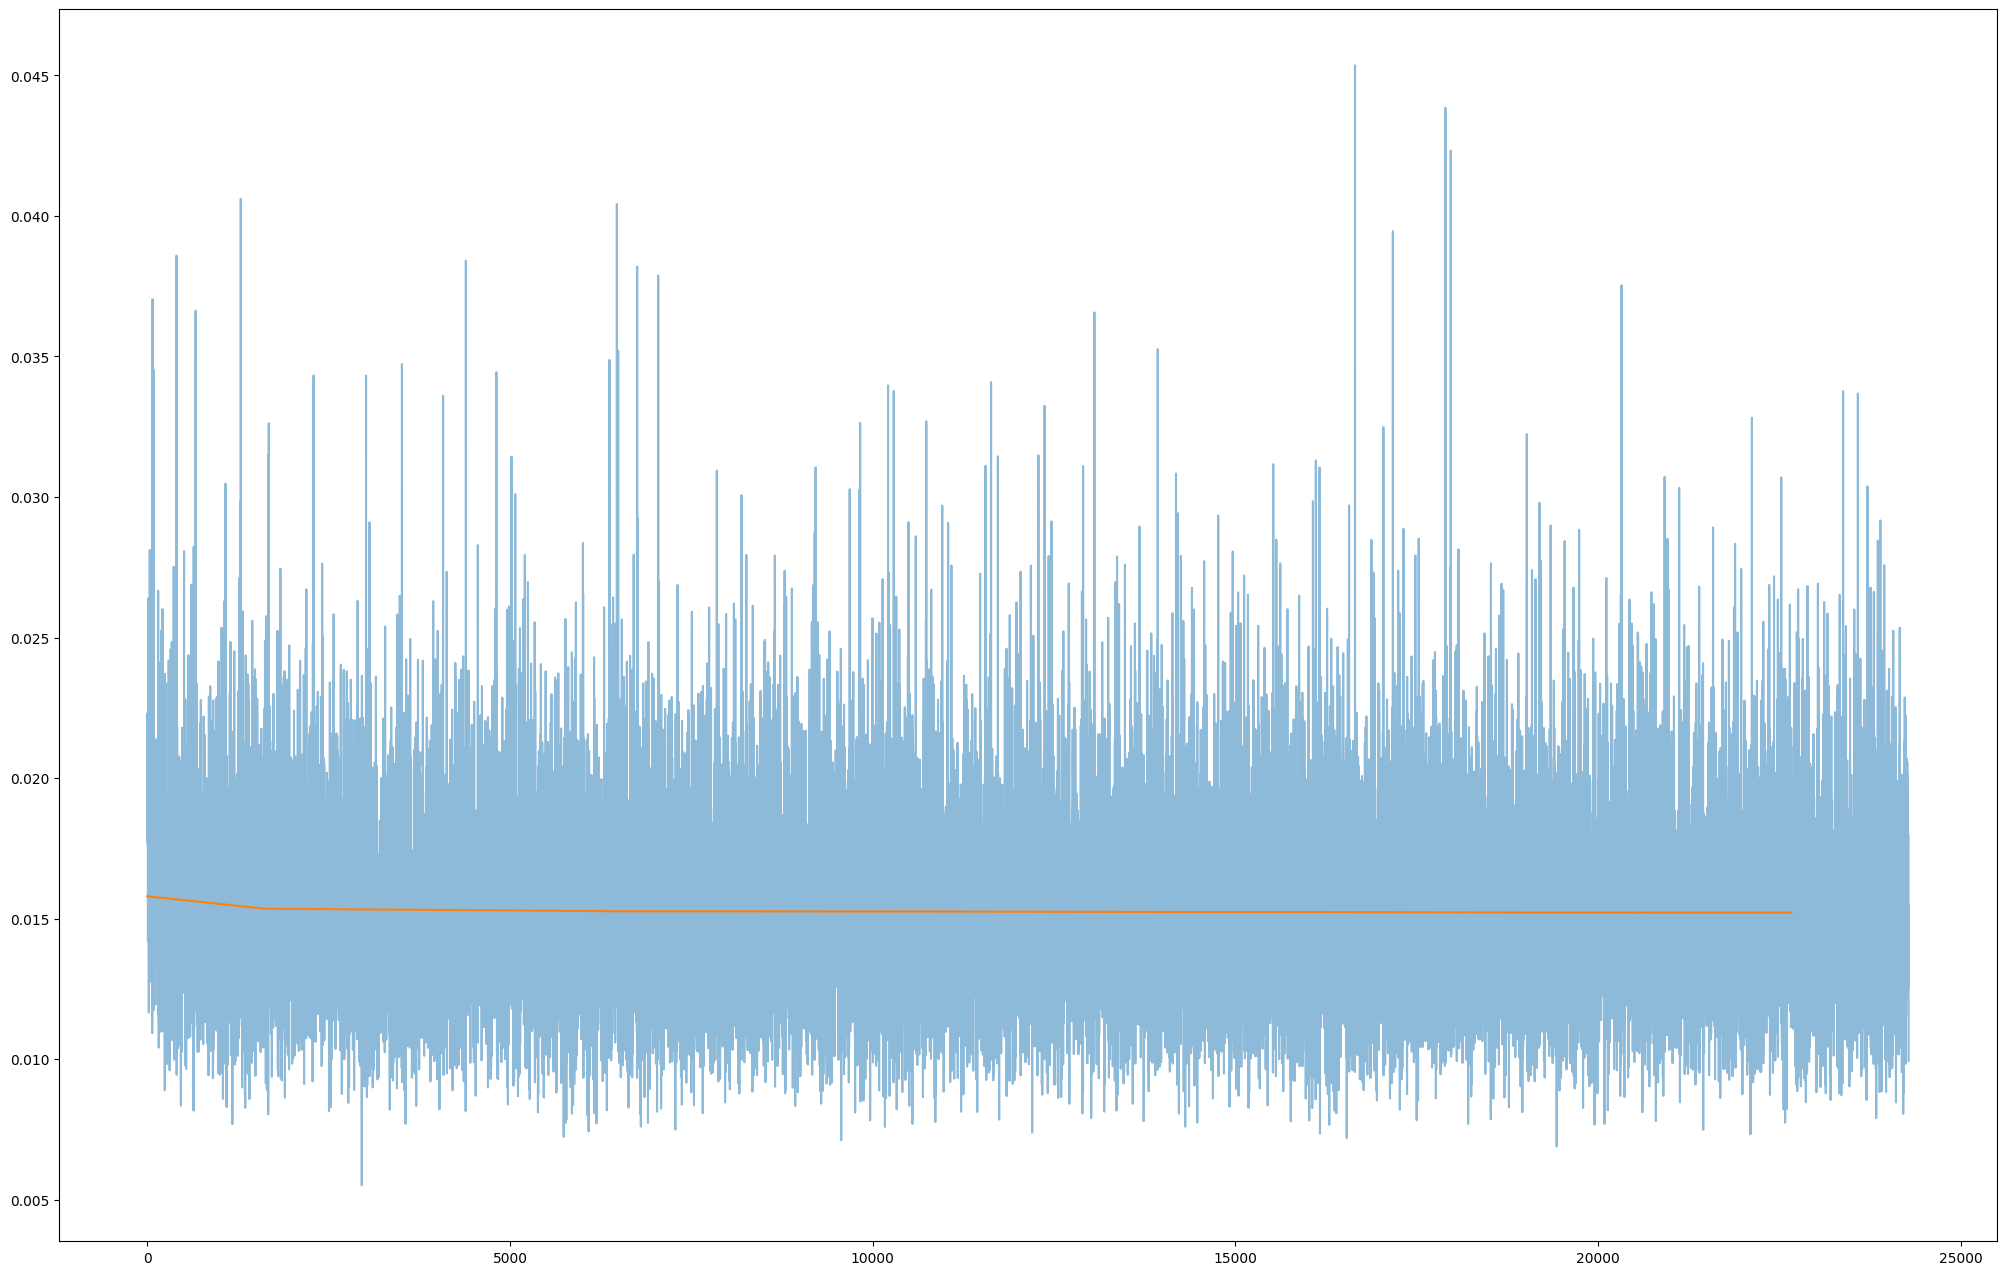

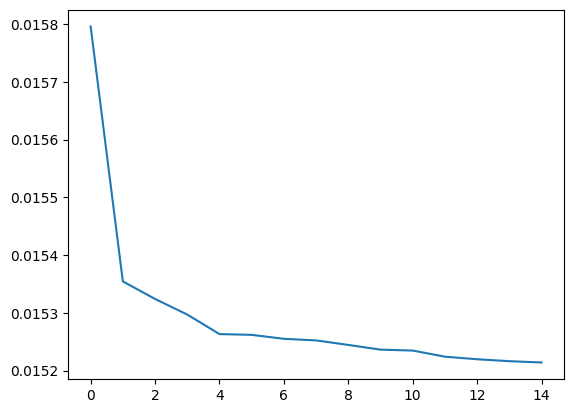

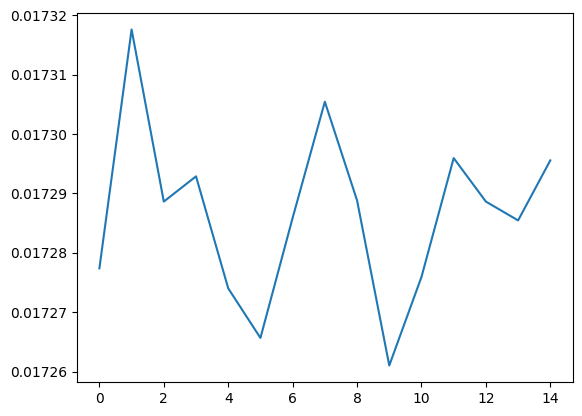

In [26]:
plt.figure(figsize=(25, 16))
plt.plot(train_losses,alpha=0.5)
plt.plot(list(range(0,len(train_losses),int(len(train_losses) / len(avarage_train_losses)))),avarage_train_losses)
plt.show()
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

In [27]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [17]:
best_model = StockLSTM()
best_model.load_state_dict(torch.load(configs["model_folder"] + "LSTM.pth.tar")['model'])

best_model.to(device)
best_model.eval()

StockLSTM(
  (layer1): LSTMBlock(
    (LSTM): LSTM(6, 512, num_layers=2, bias=False, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
    (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (layer2): Linear(in_features=512, out_features=1, bias=False)
)

In [18]:
with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = torch.mul(torch.transpose(input[:,:,:],1,2),scaler)
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

NameError: name 'test_loader' is not defined

In [19]:
def get_log_stock_prediction(model, stock_files) :
    model.eval()
    data_set = StockDatasetLogReturn(stock_files, configs["input_size"], 1)
    data_set.Preprocess()
    data_loader = DataLoader(data_set,configs["batch_size"])
    predict_res = []
    target_res = []
    
    with torch.no_grad() : 
        
        for input,target in tqdm(data_loader) :
            close_price_input = torch.mul(torch.transpose(input[:,:,:],1,2),scaler)
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)

            output = model(close_price_input)

            close_price_input = close_price_input.to(torch.device("cpu"))
            
            predict_res += output.to(torch.device("cpu")).reshape(-1).tolist()
            target_res += close_price_target.to(torch.device("cpu")).reshape(-1).tolist()

    return np.array(predict_res),np.array(target_res)


In [20]:
def trade_test(predict, real) :
    buy_pos = predict > 0
    total_profit = np.exp(np.sum(buy_pos * real))
    return total_profit

In [21]:
predict,target = get_log_stock_prediction(best_model, ["./data/A.csv"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6129 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

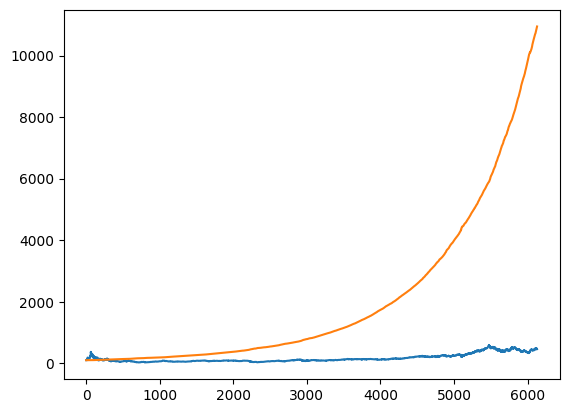

In [22]:
predict_percent = np.exp(predict)
target_percent = np.exp(target)
predict_plot = np.cumprod(predict_percent) * 100
target_plot = np.cumprod(target_percent) * 100
plt.plot(target_plot)
plt.plot(predict_plot)
plt.show()

In [23]:
total_profit = trade_test(predict,target)
print("total_profit : ",total_profit)
buy_and_hold_profit = trade_test(np.ones(target.shape),target)
print("buy and hold : ",buy_and_hold_profit)
random_profit = trade_test(np.random.randint(low=0,high=2,size=target.shape),target)
print("random profit : ",random_profit)

total_profit :  10.042625899308872
buy and hold :  4.5820224637360205
random profit :  1.3602663826185768


[]

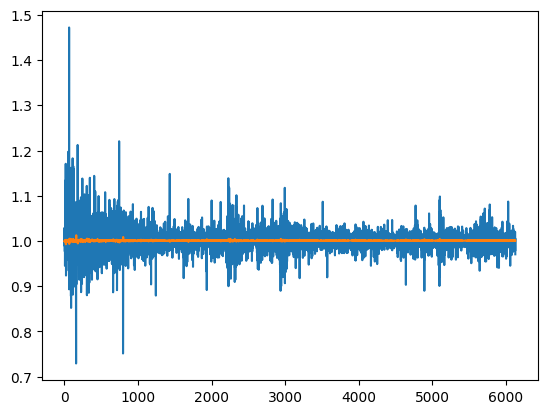

In [24]:
plt.plot(target_percent)
plt.plot(predict_percent)
plt.plot()

In [25]:
print(np.mean((np.log(np.array(target_percent)) * np.log(np.array(predict_percent))) > 0))

0.5208027410670583


In [26]:
plt.plot(learning_rates)
plt.show()

NameError: name 'learning_rates' is not defined